In [518]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
litvinenko630_real_estate_saint_petersburg_2014_2019_path = kagglehub.dataset_download('litvinenko630/real-estate-saint-petersburg-2014-2019')

print('Data source import complete.')


Data source import complete.


# Introduction | Real Estate Saint-Petersburg 2014-2019

Current dataset has been acquired from Kaggle datasets.  
It contains info about real estate listings, including various features of properties. Source:  
https://www.kaggle.com/datasets/litvinenko630/real-estate-saint-petersburg-2014-2019/data


### Goal  

Completed version of this notebook will be having a prediction baseline model able to forecast prices of real estate.

## Importing libraries, funcs & data

In [519]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [520]:
df = pd.read_csv(r'data/real_estate_data.csv', sep='\t')

## Data exploration

In [521]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [523]:
df.describe().round(decimals=2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,2.369900e+04,23699.00,23699.00,14504.00,23613.00,21796.00,23699.00,21421.00,12180.00,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
mean,9.86,6.541549e+06,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,1.088701e+07,35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,1.219000e+04,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3.400000e+06,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4.650000e+06,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6.800000e+06,69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,7.630000e+08,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


In [524]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [525]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [526]:
df.duplicated().sum()

0

In [527]:
df.nunique().sort_values()

studio                     2
open_plan                  2
is_apartment               2
ponds_around3000           4
parks_around3000           4
balcony                    6
rooms                     17
floor                     33
floors_total              36
total_images              38
ceiling_height           183
locality_name            364
kitchen_area             971
parks_nearest            995
ponds_nearest           1096
days_exposition         1141
first_day_exposition    1491
living_area             1782
total_area              2182
last_price              2978
cityCenters_nearest     7642
airports_nearest        8275
dtype: int64

In [528]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [529]:
df.shape

(23699, 22)

## Data Preprocessing

In [530]:
df['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23699, dtype: float64





There's an anomaly low last price that has to be corrected

In [531]:
df.query('last_price==12190.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [532]:
min_value = min(df['last_price'])
df.loc[df['last_price']==min_value, 'last_price'] = int(min_value*100)

In [533]:
df[df['ponds_nearest'].isna()][ 'ponds_around3000'].value_counts()

ponds_around3000
0.0    9071
Name: count, dtype: int64

In [534]:
df[df['parks_nearest'].isna()][ 'parks_around3000'].value_counts()

parks_around3000
0.0    10102
Name: count, dtype: int64

In [535]:
features_to_compare = ['airports_nearest', 'cityCenters_nearest']

df[features_to_compare] = df[features_to_compare].fillna(0)

In [536]:
from sklearn.metrics import pairwise_distances
def fulfill_by_closest(
        df: pd.DataFrame,
        features: list[str],
        features_to_compare: list[str]
):
    for feature in features:
        known_values = df[df[feature].notna()]
        unknown_values = df[df[feature].isna()]
        distances = pairwise_distances(unknown_values[features_to_compare], known_values[features_to_compare], metric='euclidean')
        nearest_indices = distances.argmin(axis=1)
        df.loc[df[feature].isna(), feature] = known_values.iloc[nearest_indices][feature].values

In [537]:
features_to_fill = ['parks_nearest','ponds_nearest','ponds_around3000','parks_around3000']
fulfill_by_closest(
    df = df,
    features = features_to_fill,
    features_to_compare = features_to_compare
)

In [538]:
df.dropna(subset=['locality_name'], inplace=True)

In [539]:
df.loc[df['floors_total'].isna(), 'floors_total'] = df.loc[df['floors_total'].isna(), 'floor']

In [540]:
df = df[df['floors_total']<=37]

In [541]:
df.loc[df['balcony'].isna()==True,'balcony']=0

In [542]:
grouped = df[df['ceiling_height'].notna()].groupby(['locality_name'])

In [543]:
df['ceiling_height'] = df.groupby('locality_name')['ceiling_height'].transform(lambda x: x.fillna(x.mean()))


In [544]:
df.dropna(subset=['ceiling_height'], inplace=True)

In [545]:
df.shape

(23527, 22)

In [546]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20779
days_exposition          3154
kitchen_area             2240
living_area              1874
ponds_nearest               0
ponds_around3000            0
parks_nearest               0
parks_around3000            0
cityCenters_nearest         0
airports_nearest            0
locality_name               0
balcony                     0
total_images                0
last_price                  0
studio                      0
floor                       0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [547]:
df.loc[df['kitchen_area'].isna(),'kitchen_area'] = np.floor(df['kitchen_area'].mean())
df.loc[df['living_area'].isna(),'living_area']= np.floor(df['living_area'].mean())


In [548]:
df = df[df['total_area']>20]

In [549]:
df.shape

(23492, 22)

In [550]:
df.loc[:,'non_living_area'] = df['total_area']-(df['living_area']+df['kitchen_area'])

In [551]:
df = df[df['non_living_area']>0]

In [552]:
df.fillna(value=0, inplace=True)

In [553]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df['exposition_year'] = df['first_day_exposition'].dt.year
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_day'] = df['first_day_exposition'].dt.day
df['exposition_weekday'] = df['first_day_exposition'].dt.weekday
df['studio'] = df['studio'].astype(int)
df['open_plan'] = df['open_plan'].astype(int)

In [554]:

df['log_last_price'] = np.log1p(df['last_price'])

## Сэмплирование

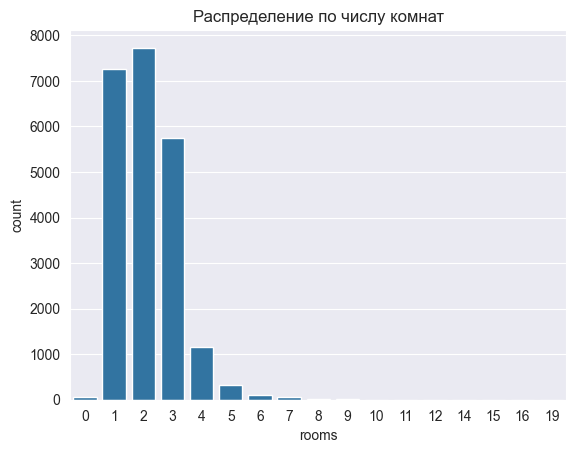

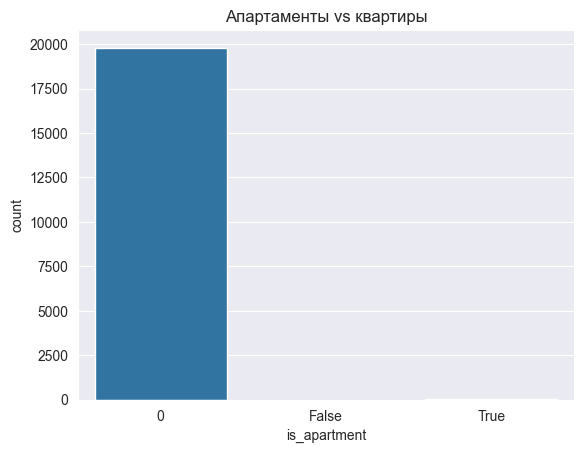

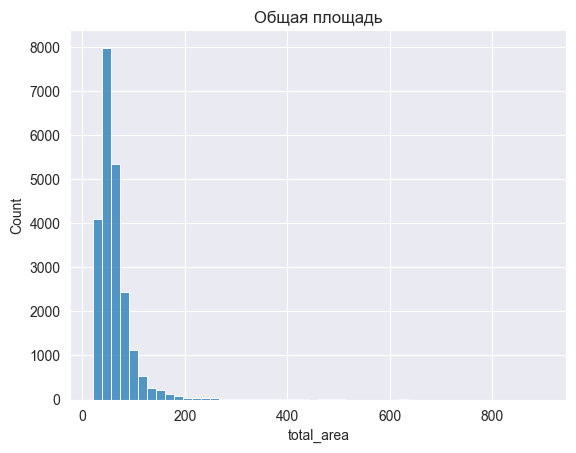

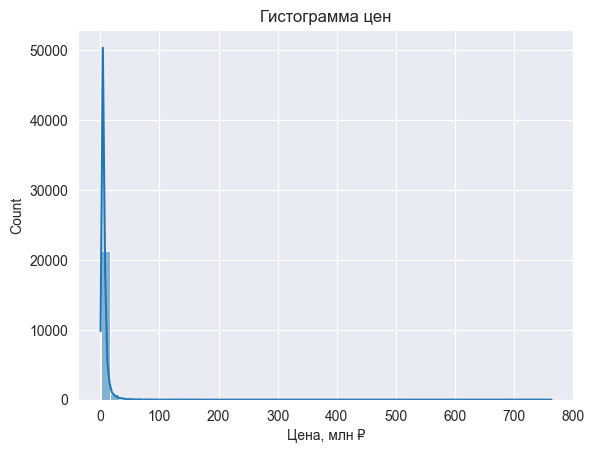

In [555]:
sns.countplot(x='rooms', data=df)
plt.title("Распределение по числу комнат")
plt.show()

sns.countplot(x='is_apartment', data=df)
plt.title("Апартаменты vs квартиры")
plt.show()

sns.histplot(df['total_area'], bins=50)
plt.title("Общая площадь")
plt.show()

sns.histplot(df['last_price'] / 1_000_000, bins=50, kde=True)
plt.xlabel("Цена, млн ₽")
plt.title("Гистограмма цен")
plt.show()

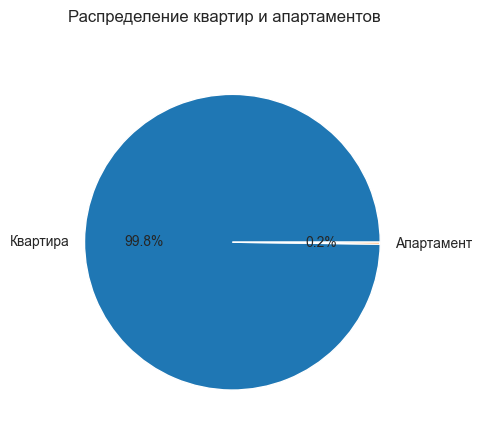

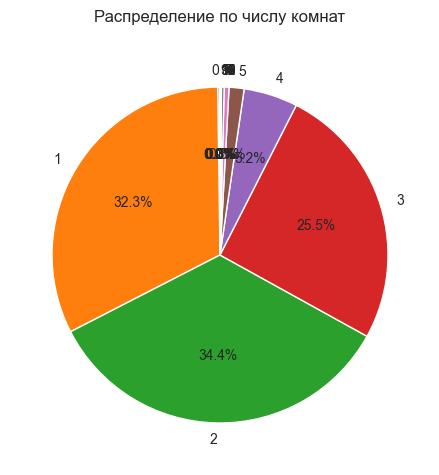

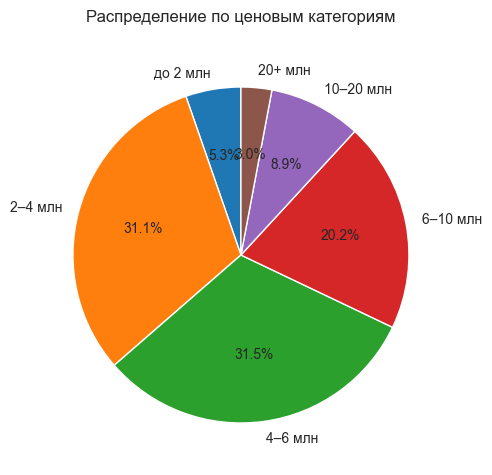

In [556]:
labels = ['Квартира', 'Апартамент']
plt.pie(df['is_apartment'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.suptitle('Распределение квартир и апартаментов')
plt.show()


room_counts = df['rooms'].value_counts().sort_index()
labels = room_counts.index.astype(str)
plt.pie(room_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по числу комнат')
plt.tight_layout()
plt.show()


bins = [0, 2, 4, 6, 10, 20, 100]
labels = ['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
df['price_category'] = pd.cut(df['last_price'] / 1_000_000, bins=bins, labels=labels)
price_counts = df['price_category'].value_counts().sort_index()
plt.pie(price_counts, labels=price_counts.index, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по ценовым категориям')
plt.tight_layout()
plt.show()

In [557]:
apartments = df[df['is_apartment'] == 1]
df = pd.concat([df, apartments] * 5, ignore_index=True)


df_1_2 = df[df['rooms'].isin([1, 2])].groupby('rooms').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)
df_rest = df[~df['rooms'].isin([1, 2])]
df = pd.concat([df_1_2, df_rest], ignore_index=True)


df['price_category'] = pd.cut(df['last_price'] / 1_000_000,
    bins=[0, 2, 4, 6, 10, 20, df['last_price'].max()/1_000_000],
    labels=['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
)

expensive = df[df['price_category'].isin(['10–20 млн', '20+ млн'])]
df = pd.concat([df, expensive] * 3, ignore_index=True)

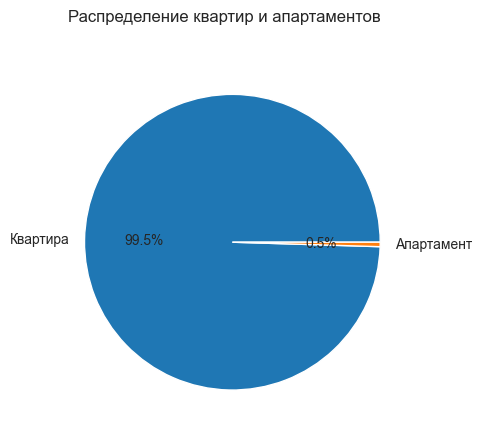

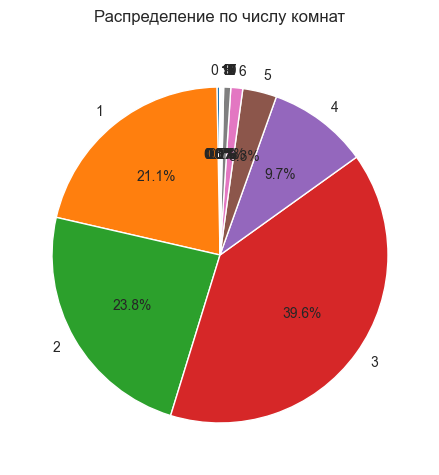

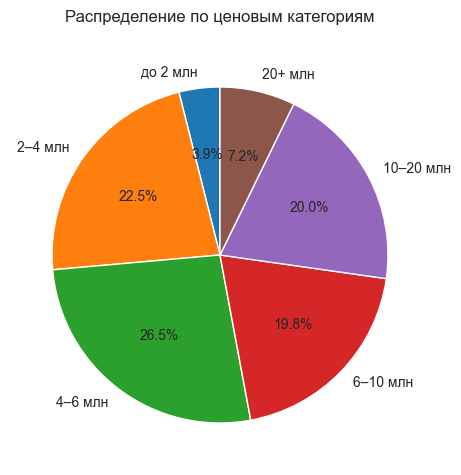

In [558]:
labels = ['Квартира', 'Апартамент']
plt.pie(df['is_apartment'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.suptitle('Распределение квартир и апартаментов')
plt.show()


room_counts = df['rooms'].value_counts().sort_index()
labels = room_counts.index.astype(str)
plt.pie(room_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по числу комнат')
plt.tight_layout()
plt.show()


bins = [0, 2, 4, 6, 10, 20, 100]
labels = ['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
df['price_category'] = pd.cut(df['last_price'] / 1_000_000, bins=bins, labels=labels)
price_counts = df['price_category'].value_counts().sort_index()
plt.pie(price_counts, labels=price_counts.index, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по ценовым категориям')
plt.tight_layout()
plt.show()

df = df.drop(axis=1, columns=['price_category'])

## Exploratory Data Analysis (EDA)

In [559]:
def create_matrix_correlation(data):
    corr = data.corr()
    fig = plt.figure(figsize=(10,10))
    sns.heatmap(
        corr, annot=True, fmt='.2f',cmap='coolwarm',cbar=True
    )
    fig.tight_layout()
    plt.show()

In [560]:
def draw_distribution_graphic(x: pd.Series)->None:
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.histplot(x, kde = True)
    ax.set_title("Target distribution", fontsize = 15, pad = 10, loc = 'left')
    ax.set_xlabel("Price - log transformed", fontsize = 8)
    ax.set_ylabel("Frequency", fontsize = 8)
    plt.show()

In [561]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,non_living_area,exposition_year,exposition_month,exposition_day,exposition_weekday,log_last_price
0,7,3490000.0,33.0,2017-08-15,1,2.600000,9.0,19.0,6,0,...,518.0,1.0,716.0,327.0,7.0,2017,8,15,1,15.065413
1,5,3900000.0,37.6,2018-09-25,1,2.750000,24.0,16.0,18,0,...,503.0,1.0,132.0,133.0,11.6,2018,9,25,1,15.176487
2,3,6050000.0,38.7,2019-03-13,1,2.700000,18.0,18.1,6,0,...,137.0,1.0,279.0,0.0,9.0,2019,3,13,2,15.615569
3,9,3500000.0,35.7,2018-10-21,1,2.803725,12.0,21.2,3,0,...,684.0,0.0,483.0,33.0,7.2,2018,10,21,6,15.068274
4,14,4600000.0,32.1,2019-01-06,1,2.500000,14.0,14.1,10,0,...,377.0,0.0,628.0,25.0,10.6,2019,1,6,6,15.341567


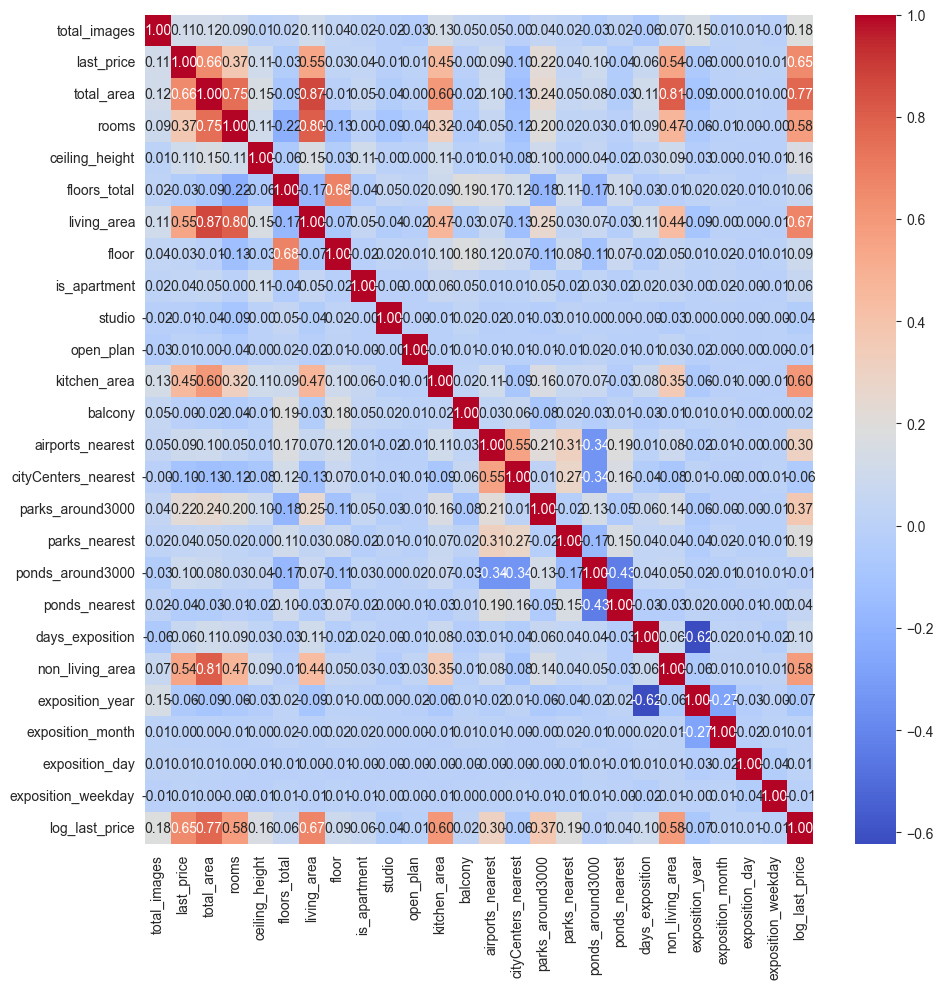

In [562]:
create_matrix_correlation(df.drop(['locality_name','first_day_exposition'],axis=1))

In [563]:
['total_area', 'rooms', 'living_area', 'is_apartment', 'kitchen_area',
       'airports_nearest', 'parks_nearest', 'non_living_area']

['total_area',
 'rooms',
 'living_area',
 'is_apartment',
 'kitchen_area',
 'airports_nearest',
 'parks_nearest',
 'non_living_area']

In [564]:
X = df.drop(['last_price','first_day_exposition','locality_name','studio', 'open_plan','log_last_price'], axis=1)

y = df['log_last_price']

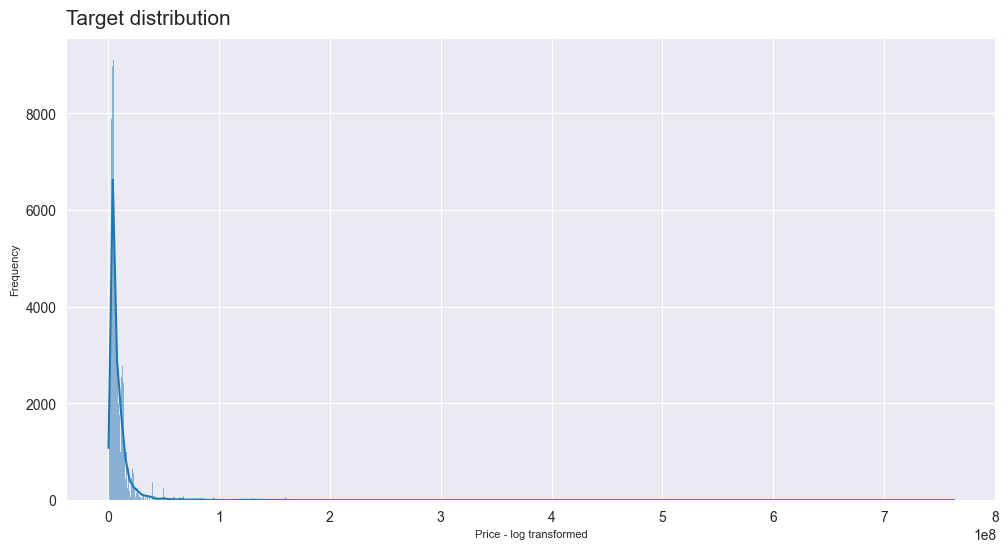

In [565]:
draw_distribution_graphic(
    x=df.last_price
)

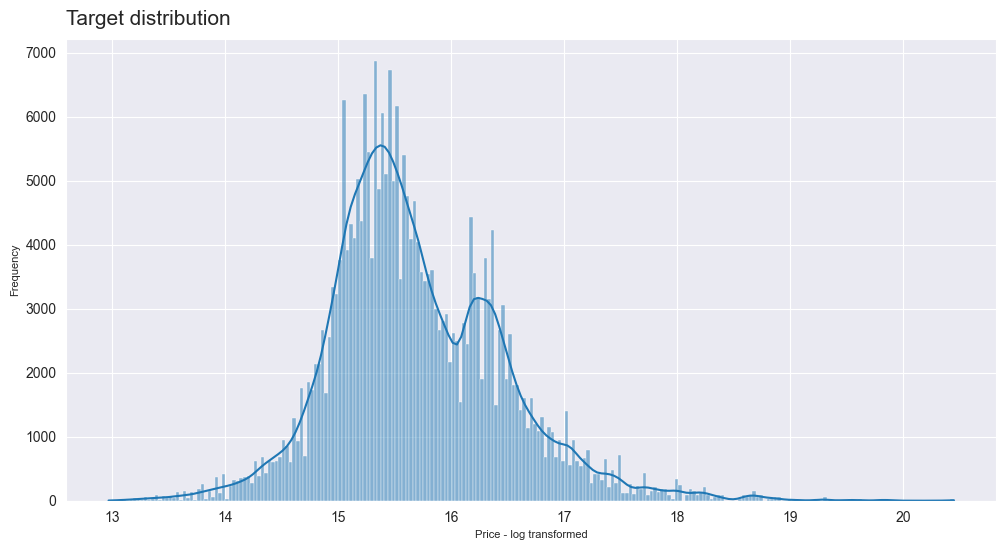

In [566]:
draw_distribution_graphic(
    x=df.log_last_price
)


## Feature Selection

In [567]:
df.isna().sum().sort_values(ascending=False)

total_images            0
last_price              0
exposition_weekday      0
exposition_day          0
exposition_month        0
exposition_year         0
non_living_area         0
days_exposition         0
ponds_nearest           0
ponds_around3000        0
parks_nearest           0
parks_around3000        0
cityCenters_nearest     0
airports_nearest        0
locality_name           0
balcony                 0
kitchen_area            0
open_plan               0
studio                  0
is_apartment            0
floor                   0
living_area             0
floors_total            0
ceiling_height          0
rooms                   0
first_day_exposition    0
total_area              0
log_last_price          0
dtype: int64

In [568]:

from sklearn.feature_selection import f_classif, SelectKBest

selector = SelectKBest(
    score_func=f_classif,
    k=12
)
X_new = selector.fit_transform(X,y)

In [569]:

X_new

array([[7, 33.0, 1, ..., 1.0, 327.0, 7.0],
       [5, 37.6, 1, ..., 1.0, 133.0, 11.600000000000001],
       [3, 38.7, 1, ..., 1.0, 0.0, 9.0],
       ...,
       [1, 177.9, 3, ..., 3.0, 0.0, 3.5],
       [12, 100.6, 7, ..., 3.0, 50.0, 56.599999999999994],
       [18, 95.0, 3, ..., 0.0, 7.0, 34.0]], dtype=object)

In [570]:
y

0         15.065413
1         15.176487
2         15.615569
3         15.068274
4         15.341567
            ...    
260854    16.361042
260855    17.216708
260856    17.855830
260857    16.417459
260858    16.447399
Name: log_last_price, Length: 260859, dtype: float64

In [571]:

selected_indices = selector.get_support(indices=True)
print("Selected feature indices:", selected_indices)

Selected feature indices: [ 0  1  2  5  7  8 10 12 13 14 16 17]


In [572]:
selected_feature_names = X.columns[selected_indices]
print("Selected feature names:", selected_feature_names)

Selected feature names: Index(['total_images', 'total_area', 'rooms', 'living_area', 'is_apartment',
       'kitchen_area', 'airports_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'days_exposition', 'non_living_area'],
      dtype='object')


## Splitting Data into Train, Validation & Test sets

In [573]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    train_size = 0.8,
    test_size = 0.2
)

In [574]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    train_size = 0.9,
    test_size = 0.1
)

In [575]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## Model building & training

In [576]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dataclasses import dataclass
import abc
from typing import Dict, Any, Type
from sklearn.model_selection import GridSearchCV


@dataclass
class ModelBuildingHelper:
    model_class: Type[abc.ABCMeta]
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    y_train: pd.Series
    y_val: pd.Series
    test_x_data: pd.DataFrame
    test_y_data: pd.Series
    params_grid: Dict[str, Any]  = None
    bagging_params: Dict[str, Any] = None
    def __post_init__(self):
        self.model_instance = self.model_class
        if self.params_grid:
            self.grid_search = GridSearchCV(
                estimator = self.model_instance,
                param_grid =  self.params_grid,
                cv = 5
            )
        else:
            self.grid_search = None

        if self.bagging_params:
            self.bagging_model = BaggingRegressor(
                estimator=self.model_instance,
                **self.bagging_params
            )
        else:
            self.bagging_model = None

    def train_model(self):
        if self.grid_search:
            self.grid_search.fit(self.X_train, self.y_train)
            self.model_instance = self.grid_search.best_estimator_
        else:
            self.model_instance.fit(self.X_train, self.y_train)


    def evaluate_model(self):
        y_val_pred = self.model_instance.predict(self.X_val)
        self.metrics(y_real=self.y_val,
                     y_pred=y_val_pred)
    def metrics(self, y_real, y_pred):
        mae = mean_absolute_error(y_real,y_pred)
        mse = mean_squared_error(y_real, y_pred)
        r2 = r2_score(y_real, y_pred)
        print(f'metrics:\n'
              f'mae {mae}\n'
              f'mse {mse}\n'
              f'r2 {r2}\n')

    def get_prediction(self):
        test_pred_data = self.model_instance.predict(self.test_x_data)
        self.metrics(self.test_y_data, test_pred_data)
    def get_best_params(self):
        if self.grid_search:
            return self.grid_search.best_params_
        else:
            raise ValueError("GridSearchCV hasn't been completed yet")

In [577]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

linear_regression = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val
)

In [578]:
linear_regression.train_model()

In [579]:
linear_regression.evaluate_model()

metrics:
mae 0.2912028245553595
mse 0.1661672896375891
r2 0.7170614562465019



In [580]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# parameters = {'n_estimators': [300],
#               'max_depth': [20],
#               'min_samples_split': [4],
#               'min_samples_leaf': [2,4]
#               }
#
# randomforest_regressor = ModelBuildingHelper(
#     model_class = model,
#     X_train=X_train_scaled,
#     X_val=X_test_scaled,
#     y_train=y_train,
#     y_val=y_test,
#     test_x_data=X_val_scaled,
#     test_y_data=y_val,
#     params_grid=parameters,
# )

In [581]:
# randomforest_regressor.train_model()

In [582]:
# randomforest_regressor.evaluate_model()

In [583]:
# randomforest_regressor.get_best_params()

In [584]:
from xgboost import XGBRegressor
from joblib import dump

model = XGBRegressor(
    gpu_id=0,
    eval_metric='rmse',
)

bagging_params = {
    'n_estimators': 5,
    'random_state': 42
}

parameters = {'n_estimators': [200,400],
              'learning_rate': [0.1],
              'max_depth': [5],
              'subsample': [1.0],
              'colsample_bytree': [0.6, 0.8],
              'alpha': [1.0],
              'lambda': [1.0],
              'min_child_weight': [6,8,10]
              }

xgb_regressor = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters,
    bagging_params=bagging_params
)


In [585]:
xgb_regressor.train_model()

In [586]:
xgb_regressor.evaluate_model()

metrics:
mae 0.14373653531648006
mse 0.03969496102513114
r2 0.9324100760667289



In [587]:
xgb_regressor.get_best_params()

with open("xgb_regressor.pkl", "wb") as f:
    dump(xgb_regressor, f, protocol=5)

In [588]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

In [589]:
extra_trees_regressor = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)
extra_trees_regressor.train_model()

In [590]:
extra_trees_regressor.evaluate_model()

metrics:
mae 0.19366395942894596
mse 0.06885586178633606
r2 0.8827568451937305



In [591]:
extra_trees_regressor.get_prediction()

metrics:
mae 0.195381794152136
mse 0.07102510553313189
r2 0.882145188096416



In [592]:

import lightgbm as lgb
model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

parameters = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
    'num_leaves': [20, 31],
    'min_child_samples': [10],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
}

lgb_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters,
)



In [593]:
lgb_regressor.train_model()

D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with f

In [594]:
lgb_regressor.evaluate_model()

metrics:
mae 0.13537830747434462
mse 0.034789239554883195
r2 0.940763210380224



D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [595]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    task_type="GPU",
    devices="0",
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    random_state=42,
    verbose=0
)


In [596]:
catboost_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)

In [597]:
catboost_regressor.train_model()

In [598]:
catboost_regressor.evaluate_model()

with open("catboost_regressor.pkl", "wb") as f:
    dump(catboost_regressor, f, protocol=5)

metrics:
mae 0.15779710103111655
mse 0.046746019911000004
r2 0.9204040047307938



In [599]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp_params = {
    'hidden_layer_sizes': [(128, 64), (256, 128)],
    'alpha': [0.0001, 0.001],  # регуляризация
    'learning_rate_init': [0.001, 0.01],
}

mlp_regressor = ModelBuildingHelper(
    model_class=mlp_model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=mlp_params,
)

In [600]:
mlp_regressor.train_model()

In [601]:
mlp_regressor.evaluate_model()

with open("mlp_regressor.pkl", "wb") as f:
    dump(mlp_regressor, f, protocol=5)

metrics:
mae 0.14474090196392153
mse 0.04120987157373334
r2 0.9298305877361848



In [602]:
from sklearn.linear_model import Lasso

model = Lasso()

parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [1000]
}

lasso_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters
)


In [603]:
lasso_regressor.train_model()

In [604]:
lasso_regressor.evaluate_model()

metrics:
mae 0.2918363261366922
mse 0.16691010514289625
r2 0.7157966397004325



In [605]:
from sklearn.ensemble import StackingRegressor
base_learners = [
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(
        n_estimators=400,
        max_depth=5,
        alpha=1.0,
        colsample_bytree=0.6,
        min_child_weight=10,
        subsample=1.0,
        learning_rate=0.1)),
    ('cbr', CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        loss_function='RMSE',
        random_state=42,
        verbose=0
    ))
]

stacking_regressor_4 = StackingRegressor(
    estimators=base_learners,
    final_estimator=XGBRegressor(
        n_estimators=400)
)

stacking_model =  ModelBuildingHelper(
    model_class=stacking_regressor_4,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)

In [606]:
stacking_model.train_model()

In [607]:
stacking_model.evaluate_model()

metrics:
mae 0.13661576813592097
mse 0.036295795560509374
r2 0.9381979476065179



In [608]:
base_learners = [
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(
        n_estimators=400,
        max_depth=5,
        alpha=1.0,
        colsample_bytree=0.6,
        min_child_weight=10,
        subsample=1.0,
        learning_rate=0.1)),
]


stacking_regressor_2 = StackingRegressor(
    estimators=base_learners,
    final_estimator= XGBRegressor(
        n_estimators=400)
)

stacking_model =  ModelBuildingHelper(
    model_class=stacking_regressor_2,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)


In [609]:
stacking_model.train_model()

In [610]:
stacking_model.evaluate_model()

metrics:
mae 0.13883148928084157
mse 0.03758029029969167
r2 0.9360107959008126



## Model comparison

In [611]:
linear_regression.get_prediction()

metrics:
mae 0.29589460183411687
mse 0.17450380996584758
r2 0.710438815322984



In [612]:
lgb_regressor.get_prediction()

metrics:
mae 0.13611865580881705
mse 0.036010673574463734
r2 0.9402460421736364



D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [613]:
xgb_regressor.get_prediction()

metrics:
mae 0.14501204957617478
mse 0.0412458524817503
r2 0.9315590994261588



In [614]:
catboost_regressor.get_prediction()

metrics:
mae 0.1592091500540873
mse 0.04849369433574159
r2 0.9195324641681428



In [615]:
lasso_regressor.get_prediction()

metrics:
mae 0.2962850239850378
mse 0.1750359581032675
r2 0.7095558005330769



In [616]:
stacking_model.get_prediction()


metrics:
mae 0.1405481450016913
mse 0.03905937188728064
r2 0.9351872145448593



In [617]:
stacking_model.get_prediction()

metrics:
mae 0.1405481450016913
mse 0.03905937188728064
r2 0.9351872145448593



## Conclusions

The preprocessing involved filling missing values using the nearest neighbors approach and applying  
a log transformation to normalize the last_price feature. Feature selection was done using  
SelectKBest with f_classif, retaining the top 12 features. Data was scaled with   
StandardScaler to ensure uniform contribution from all features.

After training and optimizing various models, it was found that the CatBoost Regressor delivered the best performance.   
The results were summarized as follows:  
CatBoost Regressor  
MAE: 0.160  
MSE: 0.056	  
R_2: 0.865  

CatBoost Regressor achieved the lowest MAE and MSE, and the highest R² score,  
making it the most effective model in this analysis.  
Overall, the preprocessing and feature selection steps contributed significantly  
to the model performance, and stacking models helped in leveraging the strengths of different algorithms.

To further improve the results, additional data preprocessing steps such as advanced feature  
 engineering and more extensive hyperparameter tuning techniques could be considered.